# Assignment 5: Solving PDEs with Fourier Analysis

We have been discussing the solutions of ordinary and partial differential equations, as well as the concepts of Fourier Series and Transforms.

The goal of this homework is to put all of that to work. 

## Table of Contents

1. [Heat equation](#The-Heat-Equation)
1. [Finite difference solution](#Finite-difference-to-solving-the-heat-equation)
1. [Spectral analysis solution](#Spectral-analysis-approach-to-solving-the-heat-equation)
1. Exercises
    1. [Exercise 1](#Exercise-1)
    1. [Exercise 2](#Exercise-2)

## The Heat Equation

A basic fact of nature is that heat flows from hot to cold, that is, from regions of high temperature to regions of low temperature. We give these words mathematical expression by stating that the rate of heat flow $\vec{H}$ through a material is proportional to the gradient of the temperature $T$ across the material:

$$
\vec{H} = -K \nabla T (x, t),
$$

where $K$ is the thermal conductivity of the material. The total amount of heat $Q(t)$ in the material at any one time is proportional to the integral of the temperature over the material’s volume

$$
Q(t) = \int d\vec{x} C \rho(\vec{x})T(\vec{x},t)
$$

where $C$ is the specific heat of the material and $\rho$ is its density. Because energy is conserved, the rate of decrease in $Q$ with time must equal the amount of heat flowing out of the material. After this energy balance is struck and the divergence theorem applied, there results the heat equation:

$$
\frac{\partial T(\vec{x},t)}{\partial t} = \frac{K}{C\rho}\nabla^2 T(\vec{x},t)
$$

The heat equation is a parabolic PDE with space and time as independent variables. The specification of this problem implies that there is no temperature variation in directions perpendicular to the bar ($y$ and $z$), and so we have only one spatial coordinate in the Laplacian:

$$
\frac{\partial T(\vec{x},t)}{\partial t} = \frac{K}{C\rho}\frac{\partial^2 T(\vec{x},t)}{\partial x^2}
$$

For this problem, the initial temperature of the bar and the boundary conditions are $T(x,t=0)=100C$, $T(x=0,t)=T(x=L,t)=0C$.

## Finite difference approach to solving the heat equation

As we did with Laplace’s equation, the numerical solution is based on converting the differential equation to a finite-difference ("difference") equation. We discretize space and time on a lattice and solve for solutions on the lattice sites. The horizontal nodes with white centers correspond to the known values of the temperature for the initial time, while the vertical white nodes correspond to the fixed temperature along the boundaries. If we also knew the temperature for times along the bottom row, then we could use a relaxation algorithm as we did for Laplace’s equation. However, with only the top row known, we shall end up with an algorithm that steps forward in time one row at a time, as in the children’s game leapfrog.

As is often the case with PDEs, the algorithm is customized for the equation being solved and for the constraints imposed by the particular set of initial and boundary conditions. With only one row of times to start with, we use a forward-difference approximation for the time derivative of the temperature:

$$
\frac{\partial T(x,t)}{\partial t} \simeq \frac{ T(x, t+\Delta t) - T(x,t) }{\Delta t}
$$

Because we know the spatial variation of the temperature along the entire top row and the left and right sides, we are less constrained with the space derivative as with the time derivative.

Consequently, as we did with the Laplace equation, we use the more accurate central-difference approximation for the space derivative:

$$
\frac{\partial^2 T(x,t)}{\partial x^2} \simeq \frac{ T(x+\Delta x, t) + T(x - \Delta x,t) - 2 T(x,t)}{\Delta x^2}
$$

Substitution of these approximations into the original expression yields the heat difference equation

$$
\frac{ T(x, t+\Delta t) - T(x,t) }{\Delta t} = \frac{K}{C \rho} \frac{ T(x+\Delta x, t) + T(x - \Delta x,t) - 2 T(x,t)}{\Delta x^2}
$$

We reorder this last expression into a form in which $T$ can be stepped forward in time $t$: 

$$
T_{i,j+1} = T_{i,j} + \eta [T_{i+1,j} + T_{i-1,j} - 2 T_{i,j}]
$$

and

$$
\eta = \frac{K\Delta t}{C\rho\Delta x^2},
$$

where $x = i\Delta x$ and $t = j\Delta t$. 

This algorithm is explicit because it provides a solution in terms of known values of the temperature. If we tried to solve for the temperature at all lattice sites simultaneously, then we would have an implicit algorithm that requires us to solve equations involving unknown values of the temperature. 

We see that the temperature at space-time point $(i, j+1)$ is computed from the three temperature values at an earlier time $j$ and at adjacent space values $i \pm 1, i$. We start the solution at the top row, moving it forward in time for as long as we want and keeping the temperature along the ends fixed at 0 K .


In [1]:
# Import the usual numpy and matplotlib libraries for numerical operations and plotting
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rng
import datetime,timeit
from mpl_toolkits.mplot3d import Axes3D

## Exercise 1

1. Write a function to solve the heat equation.
1. Define a 2-D array `T[101][2]` for the temperature as a function of space and time. The first index is for the 100 space divisions of the bar, and the second index is for present and past times (because you may have to make thousands of time steps, you save memory by saving only two times).
1. For time $t = 0 (j = 1)$, initialize $T$ so that all points on the bar except the ends are at 100 K. Set the temperatures of the ends to 0 K.
1. Apply the forward-difference approximation for the time derivative of the temperature to obtain the temperature at the next time step.
1. Assign the present-time values of the temperature to the past values: `T[i][1] = T[i][2], i = 1,... , 101.`
1. Start with 50 time steps. Once you are confident the program is running properly, use thousands of steps to see the bar cool smoothly with time. For approximately every 500 time steps, print the time and temperature along the bar.

Some things that you'll want to check, verify:
1. Check that your program gives a temperature distribution that varies smoothly along the bar and agrees with the boundary conditions
1. Check that your program gives a temperature distribution that varies smoothly with time and attains equilibrium. You may have to vary the time and space steps to obtain well- behaved solutions.
1. Make surface plots of temperature versus position for several times.

Optional:
1. Make a surface plot of temperature versus position versus time.
1. Plot the isotherms (contours of constant temperature).
1. Compare the analytic and numeric solutions (and the wall times needed to compute them). If the solutions differ, suspect the one that does not appear smooth and continuous.

We shall first write a function to solve the heat equation. 

In [150]:
def heatSolver(T,i,j,eta):
    if i != 0 and i !=len(T[0]) -1:
        return T[j][i] + eta*(T[j][i+1] + T[j][i-1] - 2*T[j][i])
    elif i == 0:
        return T[j][i] + eta*(T[j][i+1] - 2*T[j][i])
    else:
        return T[j][i] + eta*(T[j][i-1] - 2*T[j][i])
    
def heatEvolution(T,eta,numSteps, store_every = 1000):
    history = []
    Nx = len(T[0])
    for j in range(numSteps):
        for i in range(Nx):
            T[1][i] = heatSolver(T,i,0,eta)

        for i in range(Nx):
            T[0][i] = T[1][i]
        if j % store_every == 0:
            print("Time Step = " + str(j))
            plt.plot(T[0])
            plt.xlabel("X position")
            plt.ylabel("Temperature")
            history.append(T[1].copy())
            plt.show()
    return T,history
   
    



Eta = 0.35703499999999994
Time Step = 0


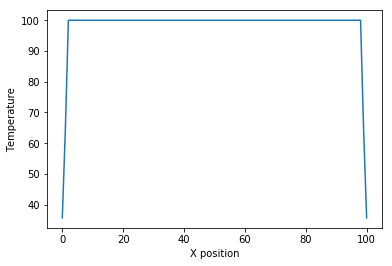

Time Step = 100


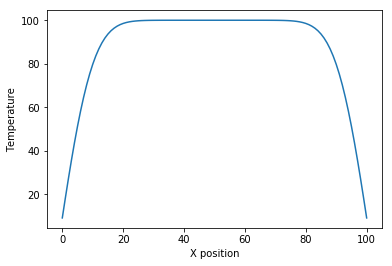

Time Step = 200


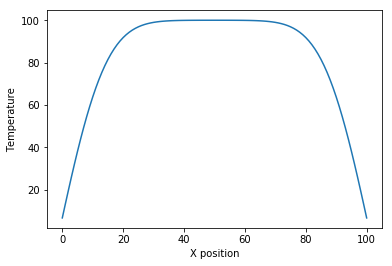

Time Step = 300


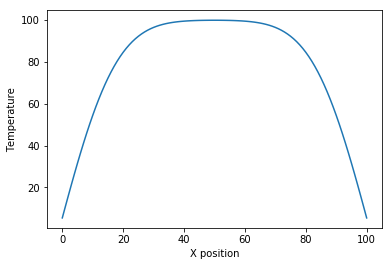

Time Step = 400


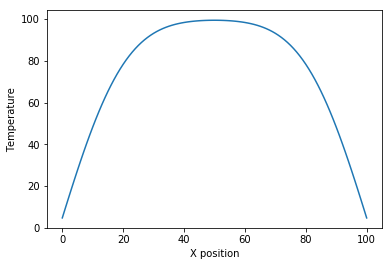

Time Step = 500


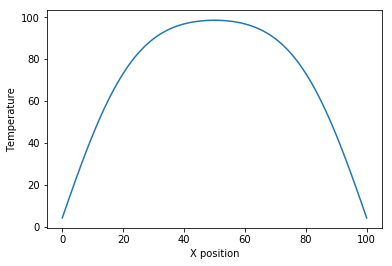

Time Step = 600


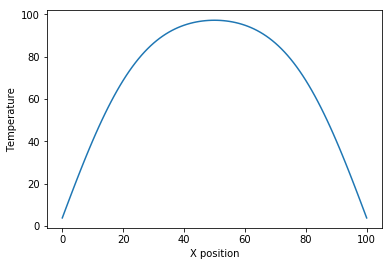

Time Step = 700


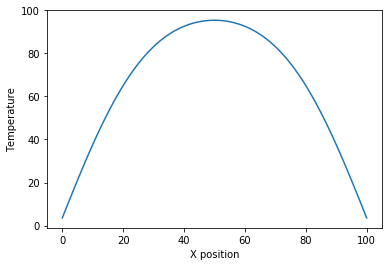

Time Step = 800


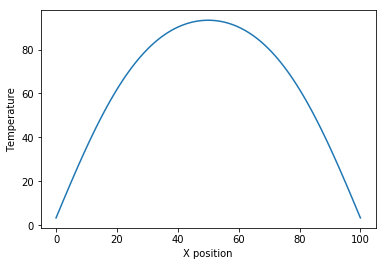

Time Step = 900


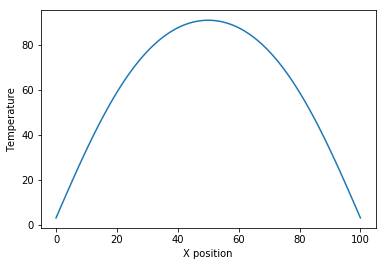

Time Step = 1000


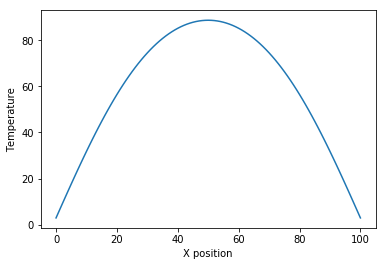

Time Step = 1100


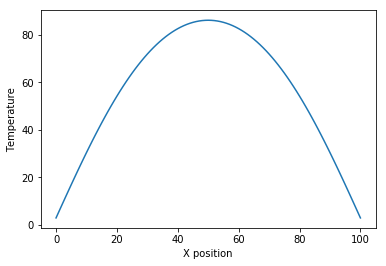

Time Step = 1200


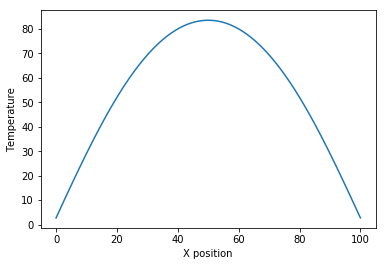

Time Step = 1300


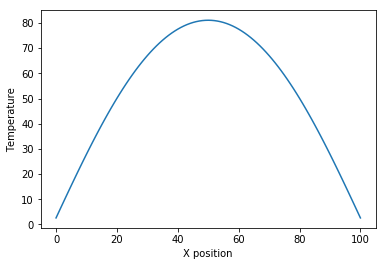

Time Step = 1400


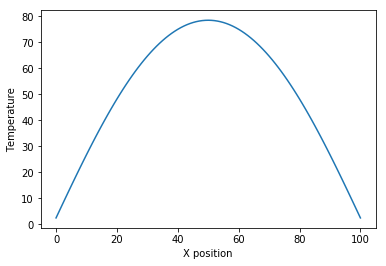

Time Step = 1500


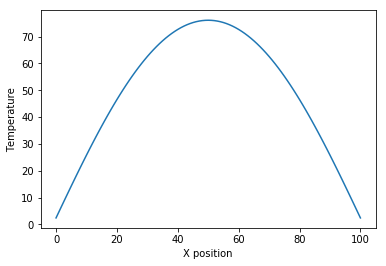

Time Step = 1600


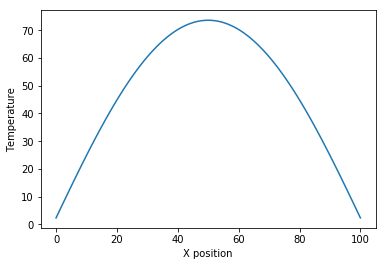

Time Step = 1700


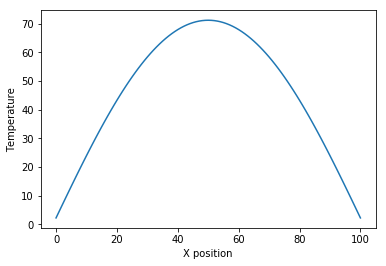

Time Step = 1800


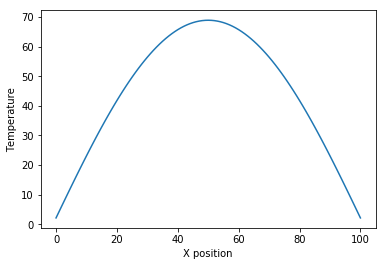

Time Step = 1900


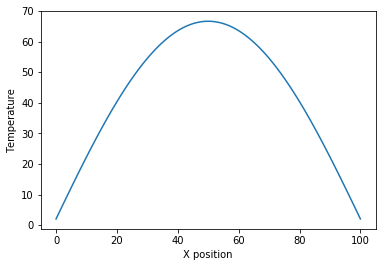

Time Step = 2000


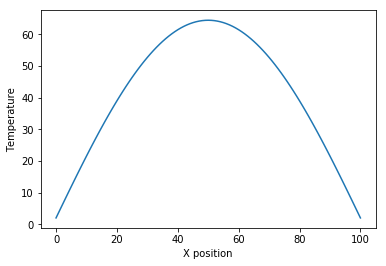

Time Step = 2100


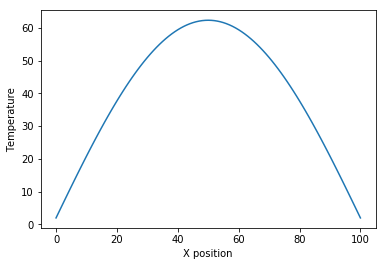

Time Step = 2200


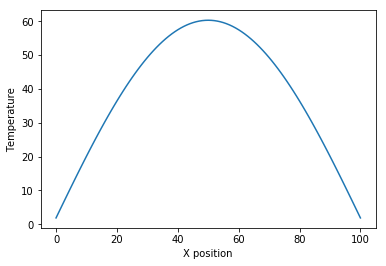

Time Step = 2300


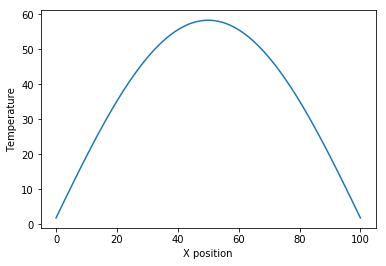

Time Step = 2400


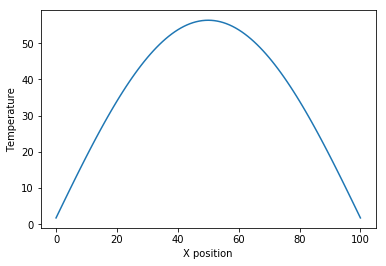

Time Step = 2500


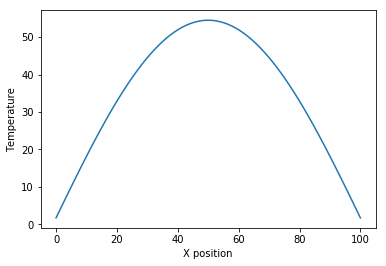

Time Step = 2600


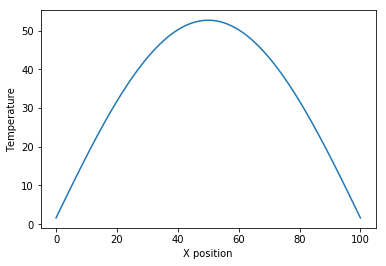

Time Step = 2700


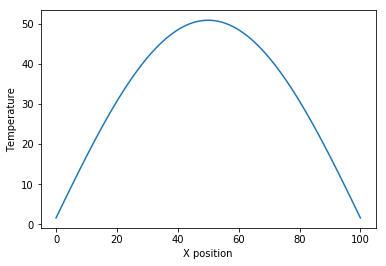

Time Step = 2800


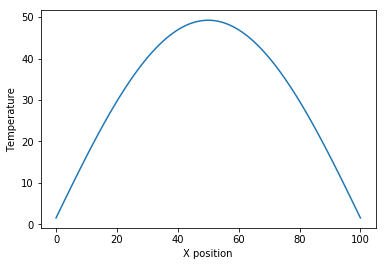

Time Step = 2900


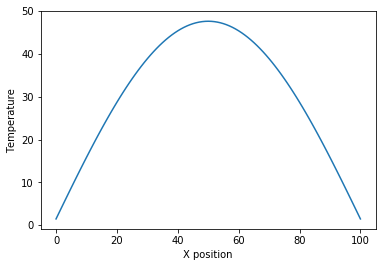

Time Step = 3000


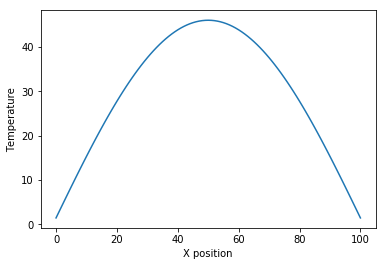

Time Step = 3100


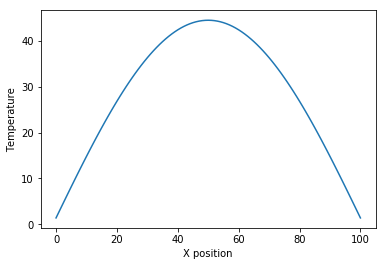

Time Step = 3200


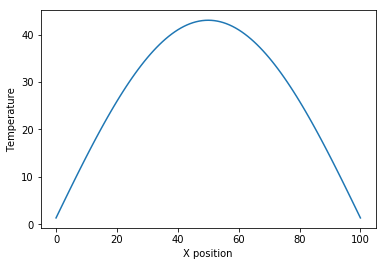

Time Step = 3300


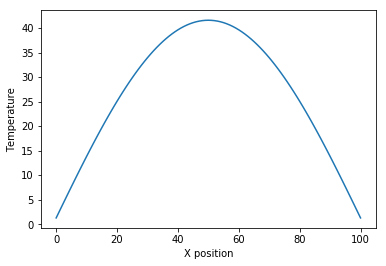

Time Step = 3400


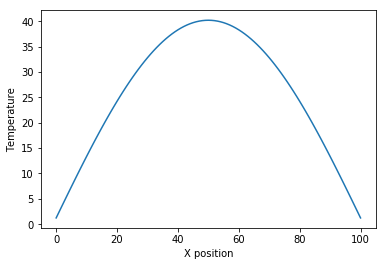

Time Step = 3500


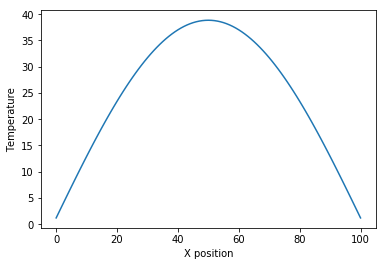

Time Step = 3600


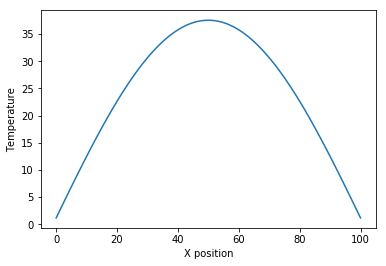

Time Step = 3700


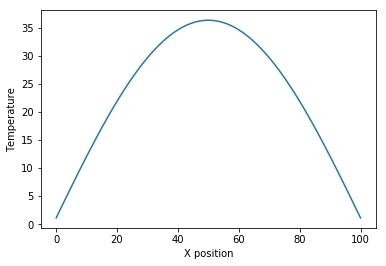

Time Step = 3800


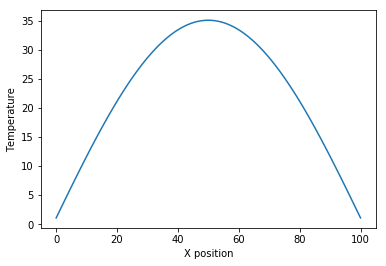

Time Step = 3900


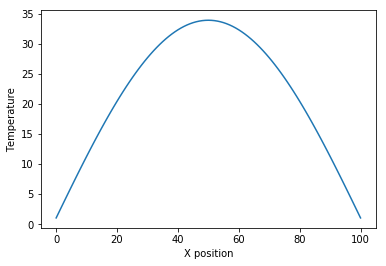

Time Step = 4000


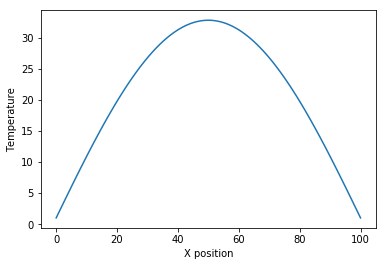

Time Step = 4100


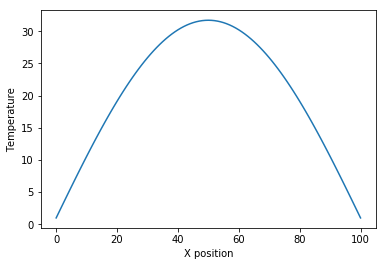

Time Step = 4200


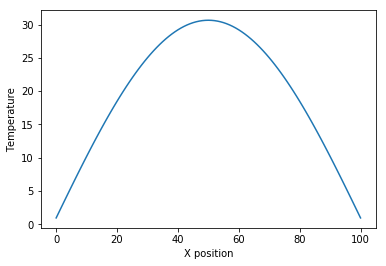

Time Step = 4300


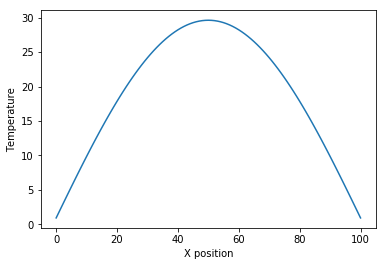

Time Step = 4400


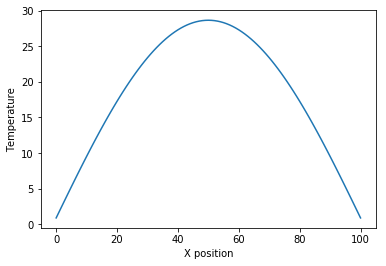

Time Step = 4500


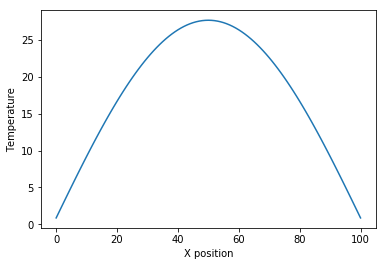

Time Step = 4600


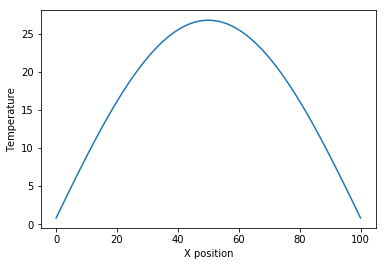

Time Step = 4700


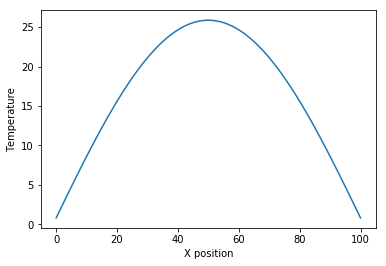

Time Step = 4800


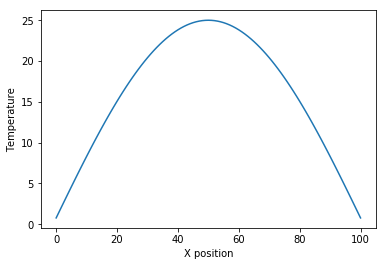

Time Step = 4900


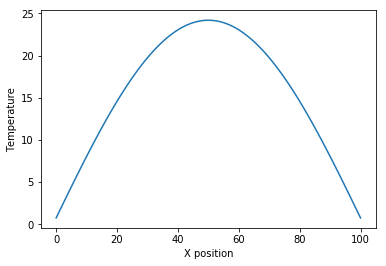

Time Step = 5000


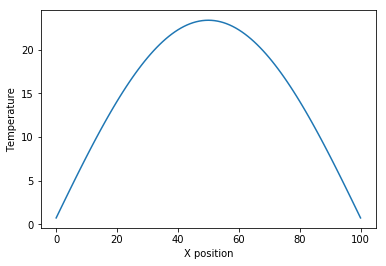

Time Step = 5100


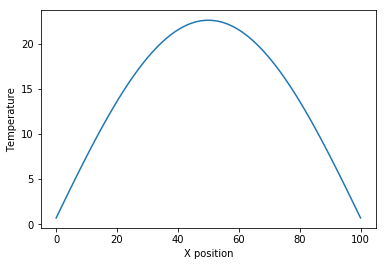

Time Step = 5200


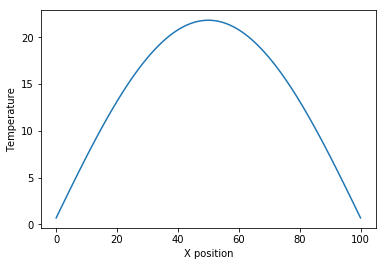

Time Step = 5300


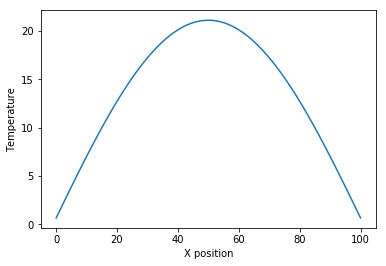

Time Step = 5400


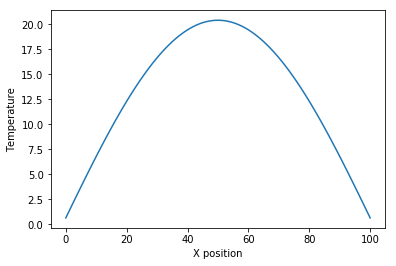

Time Step = 5500


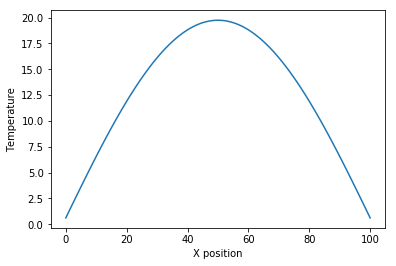

Time Step = 5600


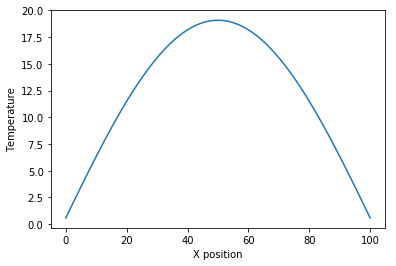

Time Step = 5700


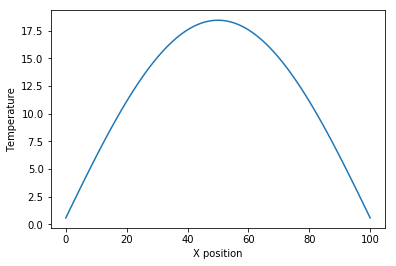

Time Step = 5800


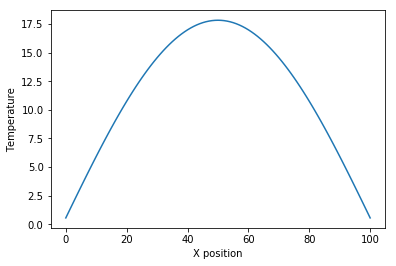

Time Step = 5900


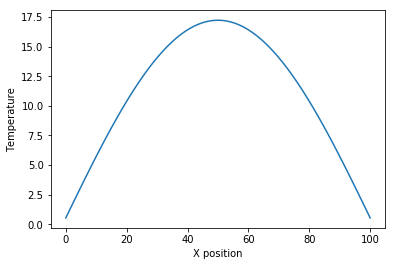

Time Step = 6000


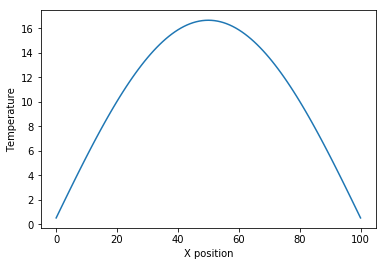

Time Step = 6100


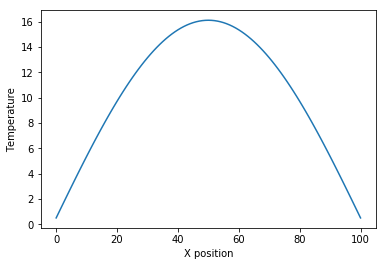

Time Step = 6200


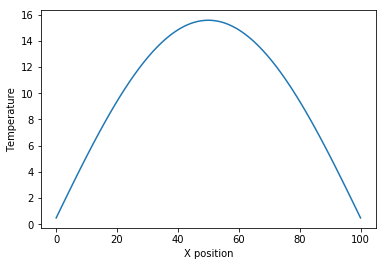

Time Step = 6300


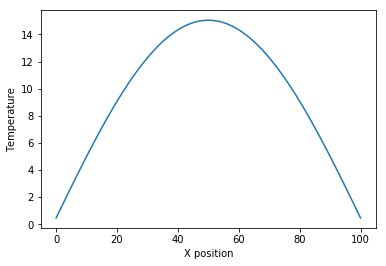

Time Step = 6400


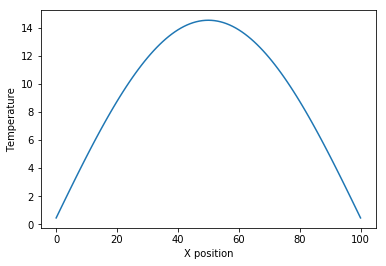

Time Step = 6500


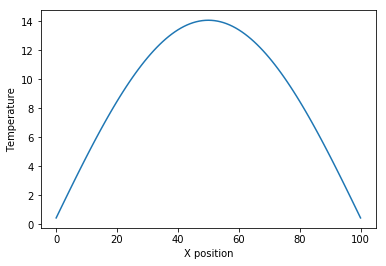

Time Step = 6600


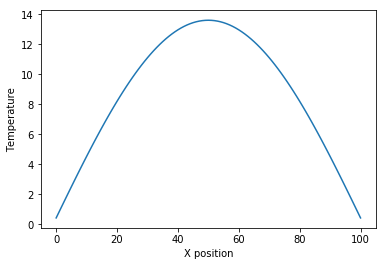

Time Step = 6700


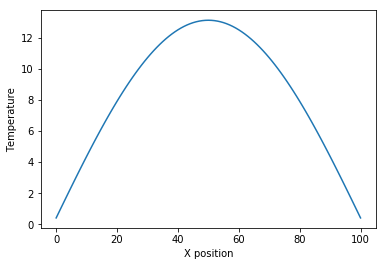

Time Step = 6800


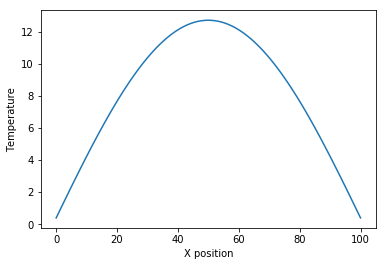

Time Step = 6900


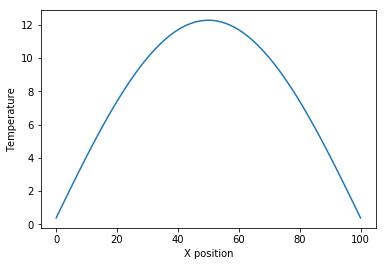

Time Step = 7000


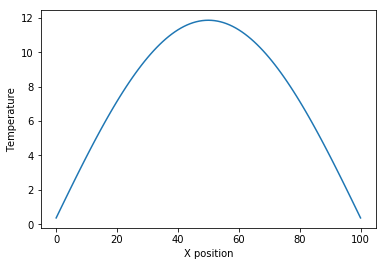

Time Step = 7100


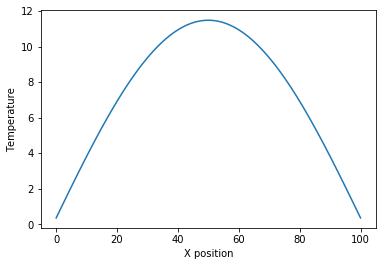

Time Step = 7200


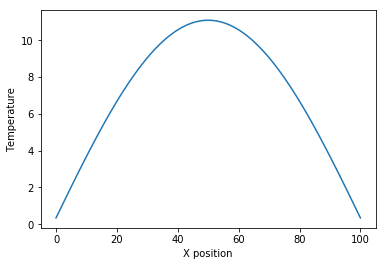

Time Step = 7300


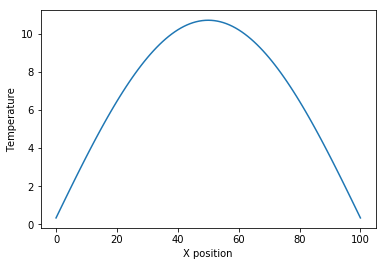

Time Step = 7400


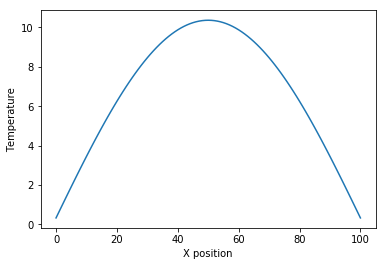

Time Step = 7500


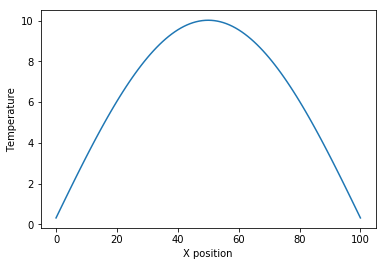

Time Step = 7600


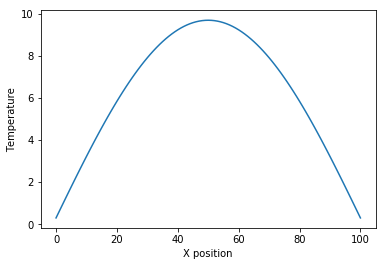

Time Step = 7700


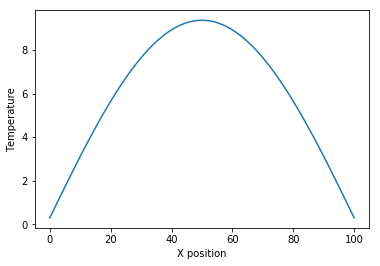

Time Step = 7800


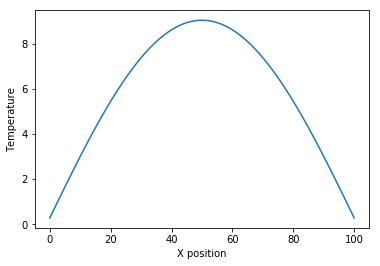

Time Step = 7900


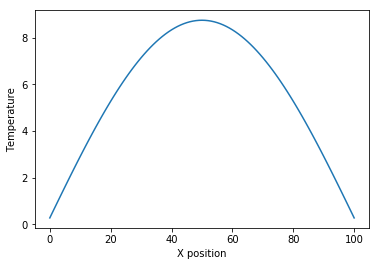

Time Step = 8000


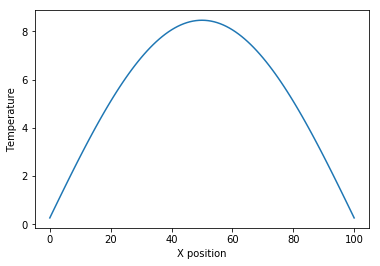

Time Step = 8100


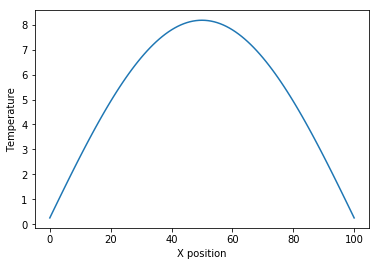

Time Step = 8200


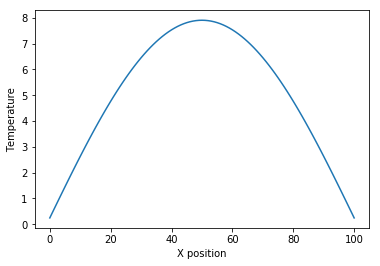

Time Step = 8300


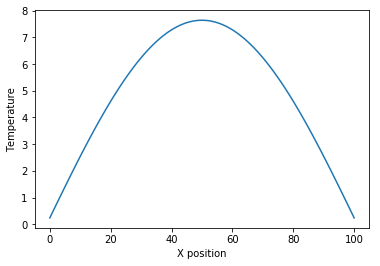

Time Step = 8400


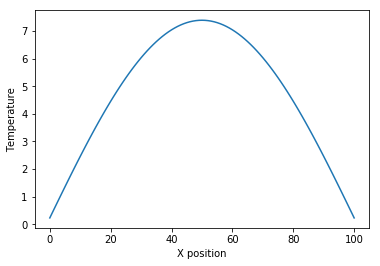

Time Step = 8500


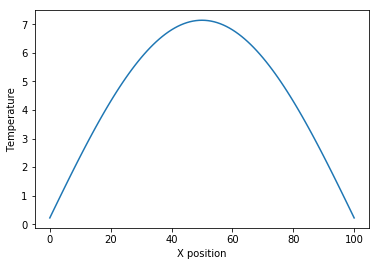

Time Step = 8600


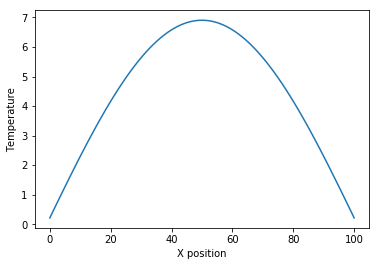

Time Step = 8700


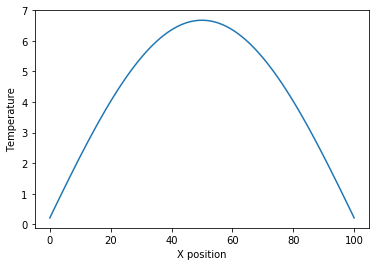

Time Step = 8800


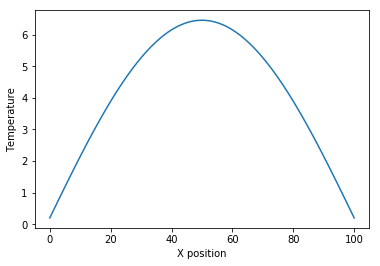

Time Step = 8900


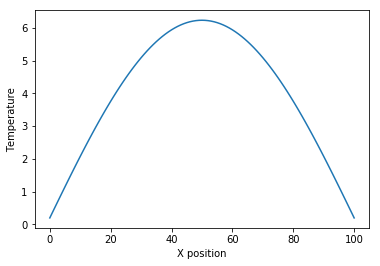

Time Step = 9000


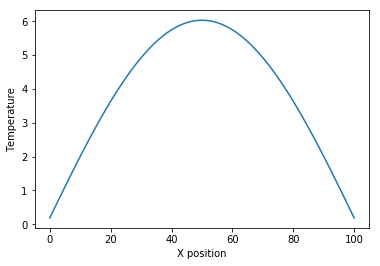

Time Step = 9100


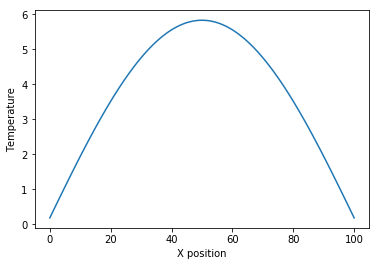

Time Step = 9200


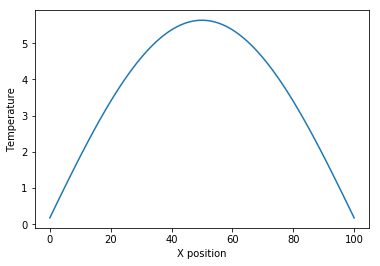

Time Step = 9300


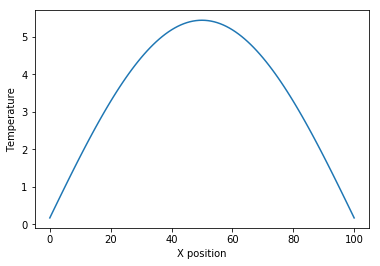

Time Step = 9400


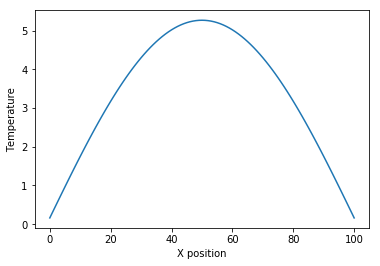

Time Step = 9500


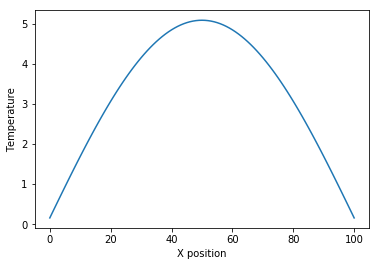

Time Step = 9600


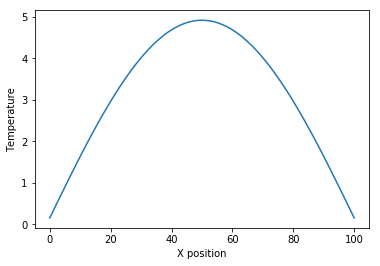

Time Step = 9700


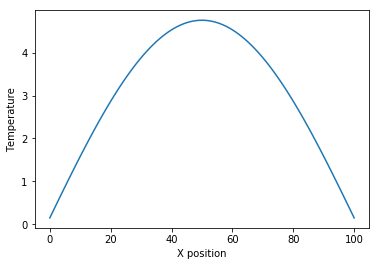

Time Step = 9800


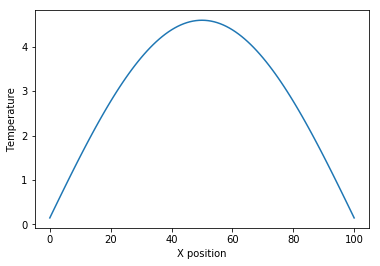

Time Step = 9900


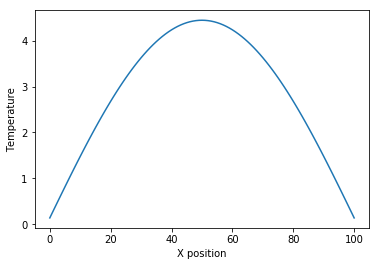

In [157]:
K = 1
C = 1
rho = 1


L  = 10; Nx = 101
x  = np.linspace(0, L, Nx)
dx = L/float(Nx)

store_every = 100
time  = 35; numSteps = 10000
t  = np.linspace(0, time, numSteps+1)
dt = time/float(numSteps)

eta = K*dt/(C*rho*dx**2)

print("Eta = " + str(eta))
#Temperature Lattice ( i = position, j = time)
T = [ [0 for i in range(Nx)] for j in range(2)]
for i in range(Nx-2):
    T[0][i+1] = 100

T,history = heatEvolution(T,eta,numSteps, store_every)


[[35.70349999999999, 64.29650000000001, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 64.29650000000001, 35.70349999999999], [9.21729372036026, 18.31249651510192, 27.168321256943393, 35.676776476625164, 43.74306242864828, 51.2886404551032, 58.253316558925775, 64.59626284551047, 70.2959853356107, 75.34932501210216, 79.76964355229912, 83.58439082474278, 86.8322752558

Text(0.5,0,'Temperature')

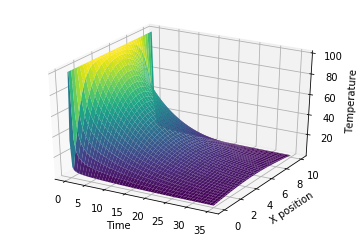

In [158]:
t = np.linspace(0,time, len(history))
t = t[ : :1]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
print(history)
history = np.array(history)
x = np.array(x)
t = np.array(t)
X,Y  = np.meshgrid(x,t)

ax.plot_surface(Y, X, history, linewidth = 1, antialiased = True,cmap='viridis')
ax.set_ylabel("X position")
ax.set_xlabel("Time")
ax.set_zlabel("Temperature")

We note that if we set $\eta$ to be greater than .5, then we will get rapidly increasing oscillatory behavior instead of a smooth temperature diffusion. This is because in the formulation of $T_{i,j+1}$, we see that if $\eta > .5$, then the evolution will be too dependent on the value of its neighbors, and they will increasingly trade temperature between them at a rate that exceed 1. Thus, a single point on the bar will oscillate, driving towards higher and higher magnitudes of temperature, not stabilizing.

## Exercise 2

In class we discussed how to implement a Fourier approximation for the sawtooth wave. Now, I want you to do the same for the following:

1. Square wave, with coefficients falling off as $\mathcal{O}(|M|^{-1})$ (Exact $\hat{y~}_M = -2 i / (\pi M), M$ odd)
1. Function $(1-0.6 \cos(2 \pi x / L))^{-1}$, with coefficients falling off *spectrally* (beyond any algebraic order) (Exact $\hat{y~}_M = 1.25 \cdot 3^{-|M|}$)
1. Function $5 \sin(2 \pi x / L) + 2 \cos(3 \pi x / L) + \sin(5 \pi x / L)$ and decompose this into its components; then check that there are three of them in the ratio 5:2:1 (or 25:4:1 if a power spectrum is plotted) and that they resum to give the input signal.

You should find that the smoother the function the fewer Fourier coefficients we need to have hanging around in order for us to approximate the functions $y(x)$.

## Spectral analysis approach to solving PDEs

An additional way to solve PDEs in an efficient way other than multigrid methods is by using spectral methods which are based on expressing the solution as a Fourier series. 

The basic idea behind the Fourier series is to express a function as a sum of simpler functions. The Fourier series uses cosine and sine functions as its basis functions, often expressed with exponential functions. The periodic function $f$ is associated with the Fourier series

$$
f(x) = \sum_{k=-\infty}^{\infty} c_k e^{i 2 \pi k x/L}
$$

where $c_k$ are the Fourier coefficients, $k$ represents the frequency and $L$ the spatial grid length. It is the Fourier coefficients that need to be calculated in order to satisfy the equality above. To find these coefficients we use the essential orthogonality properties of the exponential functions.

Such an approach is called the [Spectral Method](https://en.wikipedia.org/wiki/Spectral_method)

One perspective we can take to formulate spectral methods is one where we want to reconstruct/deconstruct periodic functions $y(x)$ of some wave-length $L$, based on its values at the discrete set of $N$ equally spaced points
$$
    x_n = \frac{(n-1) L}{N}.
$$

Consider the Fourier coefficients of our function $y(x)$,
$$
    \hat{y~}_m = \frac{1}{L} \int^L_0 y(x) \exp(-i k(m) x) dx, \quad m = 0, \pm 1, \pm 2, \ldots
$$
where the wave number associated with the Fourier coefficient $m$ is
$$
    k(m) = \frac{2 \pi m}{L}.
$$
From these coefficients we can reconstruct the function $y(x)$ as
$$
    y(x) = \sum^\infty_{m=-\infty} \hat{y~}_m \exp(i k(m) x).
$$

In [106]:


def I(x,L):
    return np.sin(2*np.pi*x) + 0.5*np.sin(4*np.pi*x) + 0.1*np.sin(6*np.pi*x)
def func1(x,L):
    return 1/(1-.6*np.cos(2*np.pi*x))
def func2(x,L):
    return 5*np.sin(2*np.pi*x) + 2*np.cos(3*np.pi*x) + np.sin(5*np.pi*x)

Coefficients for the square wave are $\hat y_m = \frac{-2i}{\pi m}$ for $m$ odd such that $y(x) = \sum \frac{-2i}{\pi m} exp(\frac{2 \pi i m}{L})$, where we sum over odd values.

In [147]:
m_initial = 31                 
T_period  = 2.

In [148]:
def FourierSquare(M,T,t):                      # M = number waves, T = period, t = time
    sumy  = 0                            # initialize the output                                           # Sign of the coefficient                                     
    for m in range(-M,M,2):                 # M variable selected with slider
        sumy += -2j/(np.pi*m) *np.exp(2 *np.pi*1j* m*t/T_period) # value of the function after adding next term                                         # swap the sign of the coefficient    
    return sumy

/Users/michaelhaas/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


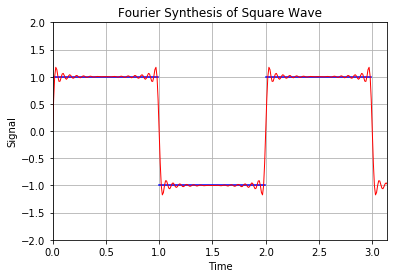

In [149]:
fig, ax = plt.subplots()
t  = np.arange(0.0, np.pi, 0.01)               
t1 = np.arange(0.0,T_period/2,0.01)               
t2 = t[100:200] 
t3 = t[200:300]
f1 = [1 for i in range(len(t1))]                                 
f2 = [-1 for i in range(len(t2))]
s  = 0 
plt.plot(t1,f1,'b')
plt.plot(t2,f2,'b')
plt.plot(t3,f1,'b')
s = FourierSquare(m_initial, T_period,t)   
fig.gca()
lines, = plt.plot(t, s, lw=1, color='red')
plt.axis([0, np.pi, -2.0, 2.0])

plt.axis([0, np.pi, -2.0, 2.0])             # minx, maxx, miny, maxy
plt.xlabel('Time')                                        
plt.ylabel('Signal')                                      
plt.title('Fourier Synthesis of Square Wave')
plt.grid(True) 

Now to do function 1. We know that $\hat y_m = \frac{1.25}{3^{|m|}}$, such that $y(x) = \sum \frac{1.25}{3^{|m|}} exp(\frac{2 \pi i m}{L})$

In [139]:
m_initial =  5                   
T_period  = 1.

In [140]:
def Fourier1(M,T,t):                      # M = number waves, T = period, t = time
    sumy  = 0                            # initialize the output                 
    omega = 2.*np.pi/T_period            # Omega = 2pi/T
    sign  = 1                            # Sign of the coefficient                                     
    for m in range(1,M):                 # M variable selected with slider
        sumy += 1.25/(3**(np.abs(m)))*np.exp(2 *1j*np.pi* m*t/T_period) # value of the function after adding next term                                          # swap the sign of the coefficient    
    sumy = (2.0)*sumy  +  1.25           # Doubling for -m and accounting for m = 0
    return sumy

/Users/michaelhaas/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


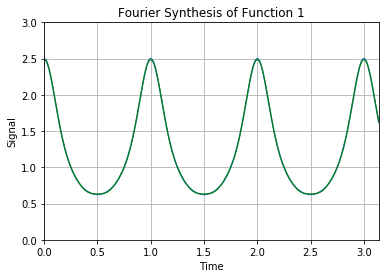

In [144]:

fig, ax = plt.subplots()
t  = np.arange(0.0, np.pi, 0.01)               
t1 = np.arange(0.0,T_period/2,0.01)               
t2 = t[100:300]                               
f1 = t1                                 
f2 = t2-T_period                                  
s  = 0 
plt.plot(t,func1(t,T_period))                                    
s = Fourier1(m_initial, T_period,t)   
fig.gca()
lines, = plt.plot(t, s, lw=1, color='green')
plt.axis([0, np.pi, -4.0, 3.0])

plt.axis([0, np.pi, 0, 3.0])             # minx, maxx, miny, maxy
plt.xlabel('Time')                                        
plt.ylabel('Signal')                                      
plt.title('Fourier Synthesis of Function 1')
plt.grid(True) 

We see that for $m>5$, we perfectly approximate the function, which means that 

Now we shall do the function 2. We shall first decompose it using the discrete fourier transform to find the coefficients that correspond to the three frequencies that make up the sum. We see that we indeed get peak values of 250,100,50, which is indeed in the ratio of 5:2:1. We know that the fourier series for this function is actually the function itself if m_initial > 5, since it is made up of these elementary sine functions. We can represent this with the exponential form by having our fourier coefficients appropriately multiplied in order to get either a sine or cosine function. We see that if the number of terms is less than 5, than we only get certain terms of the function.

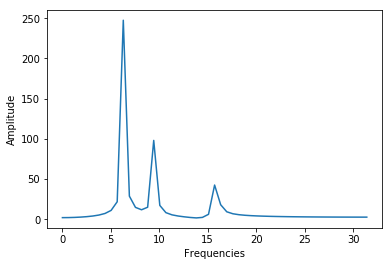

In [107]:

# Mesh
L  = 10; Nx = 100
x  = np.linspace(0, L, Nx+1)
dx = L/float(Nx)

# Discrete Fourier transform
A = np.fft.rfft(func2(x,L))
A_amplitude = np.abs(A)

# Compute the corresponding frequencies
freqs = np.linspace(0, np.pi/dx, A_amplitude.size)

plt.plot(freqs, A_amplitude)
plt.ylabel("Amplitude")
plt.xlabel("Frequencies")
plt.show()

In [108]:
m_initial = 6
T_period = 1.

In [109]:
def Fourier2(M,T,t):                      # M = number waves, T = period, t = time
    sumy  = 0                            # initialize the output                 
    y_m = [0 for i in range(M)]
    if M > 5:
        y_m[2] = -5j
        y_m[3] = 2
        y_m[5] = -1j 
    elif M >3:
        y_m[2] = -5j
        y_m[3] = 2
    elif M > 2:
        y_m[2] = -5j
    for m in range(0,M):                 # M variable selected with slider
        sumy += y_m[m]*np.exp(1j*np.pi* m*t/T_period) # value of the function after adding next term                     
                                 
                   # Doubling and accounting for -m
    return sumy

/Users/michaelhaas/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


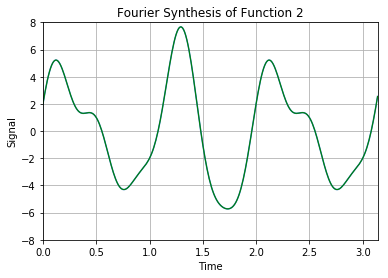

In [110]:

fig, ax = plt.subplots()
t  = np.arange(0.0, np.pi, 0.01)               
t1 = np.arange(0.0,T_period/2,0.01)               
t2 = t[100:300]                               
f1 = t1                                 
f2 = t2-T_period                                  
s  = 0 
plt.plot(t,func2(t,T_period))                                    
s = Fourier2(m_initial, T_period,t)   
fig.gca()
lines, = plt.plot(t, s, lw=1, color='green')
plt.axis([0, np.pi, -4.0, 4.0])

plt.axis([0, np.pi, -8.0, 8.0])             # minx, maxx, miny, maxy
plt.xlabel('Time')                                        
plt.ylabel('Signal')                                      
plt.title('Fourier Synthesis of Function 2')
plt.grid(True) 